<a href="https://colab.research.google.com/github/ganeshhep/FCC/blob/main/H_qq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastjet
!pip install uproot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.4/871.4 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.5/363.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.0 MB/s eta 0:00:00


In [2]:
import uproot
from fastjet import PseudoJet, JetDefinition, ClusterSequence, antikt_algorithm, sorted_by_pt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data_file = "/content/drive/MyDrive/ML_HEP/Data_files/fcc_ee_h_qq.root"
tree = uproot.open(data_file)["events"]

Mounted at /content/drive


In [4]:
tree.num_entries # total number of events

100000

In [6]:
tree.keys()

['Muon#0',
 'Muon#0/Muon#0.index',
 'Muon#0/Muon#0.collectionID',
 'ReconstructedParticles',
 'ReconstructedParticles/ReconstructedParticles.type',
 'ReconstructedParticles/ReconstructedParticles.energy',
 'ReconstructedParticles/ReconstructedParticles.momentum.x',
 'ReconstructedParticles/ReconstructedParticles.momentum.y',
 'ReconstructedParticles/ReconstructedParticles.momentum.z',
 'ReconstructedParticles/ReconstructedParticles.referencePoint.x',
 'ReconstructedParticles/ReconstructedParticles.referencePoint.y',
 'ReconstructedParticles/ReconstructedParticles.referencePoint.z',
 'ReconstructedParticles/ReconstructedParticles.charge',
 'ReconstructedParticles/ReconstructedParticles.mass',
 'ReconstructedParticles/ReconstructedParticles.goodnessOfPID',
 'ReconstructedParticles/ReconstructedParticles.covMatrix[10]',
 'ReconstructedParticles/ReconstructedParticles.clusters_begin',
 'ReconstructedParticles/ReconstructedParticles.clusters_end',
 'ReconstructedParticles/ReconstructedParti

In [7]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Muon#0               | vector<podio::ObjectID>  | AsGroup(<TBranchElement 'Mu...
Muon#0/Muon#0.index  | int32_t[]                | AsJagged(AsDtype('>i4'))
Muon#0/Muon#0.col... | int32_t[]                | AsJagged(AsDtype('>i4'))
ReconstructedPart... | vector<edm4hep::Recon... | AsGroup(<TBranchElement 'Re...
ReconstructedPart... | int32_t[]                | AsJagged(AsDtype('>i4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
R

In [8]:
p_status = tree['Particle.generatorStatus'].array() # Generator status of particles. The generator status is 1 for stable particles.
m = tree['Particle.mass'].array() # Masses of particles
px = tree['Particle.momentum.x'].array() # X-momentum of particles
py = tree['Particle.momentum.y'].array() # Y-momentum of particles
pz = tree['Particle.momentum.z'].array() # Z-momentum of particles

In [9]:
# Function to calculate energy
def energy(m, px, py, pz):
    E = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    return E

In [10]:
e = energy(m, px, py, pz) # Energy of particles

In [11]:
def f(R) : # R is the radius parameter
  n_jets = [] # a list containing number of jets in dijet events
  dijet_m = [] # a list containing invariant mass of dijet
  dijet_pt = [] # a list containing pT of dijet
  dijet_eta = [] # a list containing eta of dijet

  N = 10000 # number of events

  for n in range(N) : # taking upto N events
    particles_list = [] # a list of particles in an event

    sts = p_status[n]
    p_x = px[n]
    p_y = py[n]
    p_z = pz[n]
    E = e[n]

    for i in range(len(p_x)) : # looping over the particles in an event
      part_p4 = PseudoJet(float(p_x[i]), float(p_y[i]), float(p_z[i]), float(E[i]))
      part_p4.set_user_index(i) # setting the index of the particle
      particles_list.append(part_p4)

    stable_p4 = [] # stable particles

    for i in range(len(particles_list)) :
      if sts[i] == 1 :
        stable_p4.append(particles_list[i])

    # Applying clustering of particles with anti-kt algorithm
    cluster = ClusterSequence(stable_p4, JetDefinition(antikt_algorithm, R))
    jet_set = sorted_by_pt(cluster.inclusive_jets()) # jets obtained from inclusive form of clustering algorithm, sorted by pT (decreasing pT)

    if len(jet_set) > 1 :
      # Dijet kinematics
      dijet = jet_set[0] + jet_set[1]
      d_m = dijet.m() # invariant mass
      d_pt = dijet.pt() # transverse momentum
      d_eta = dijet.eta() # pseudo rapidity
      d_e = dijet.e() # energy

      n_jets.append(len(jet_set))
      dijet_m.append(d_m)
      dijet_pt.append(d_pt)
      dijet_eta.append(d_eta)

  return n_jets, dijet_m, dijet_pt, dijet_eta

In [12]:
R = f(0.8)

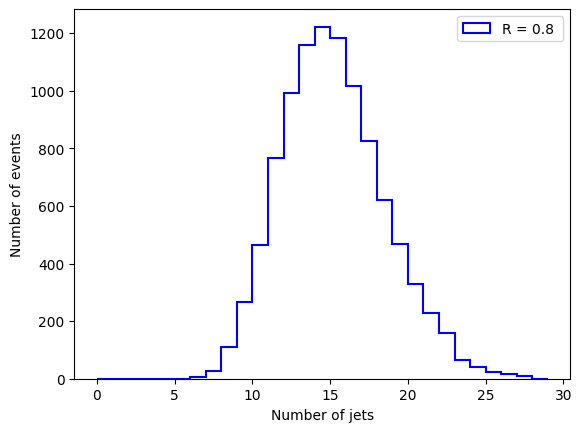

In [13]:
n_jets = R[0]
plt.hist(n_jets, bins = np.arange(0, 30), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of jets")
plt.ylabel("Number of events")
plt.legend()
plt.show()

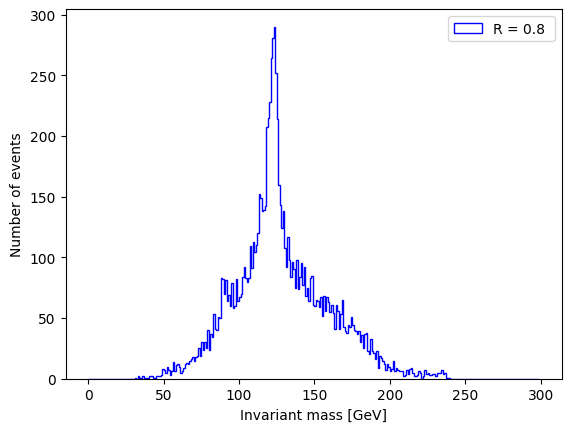

In [14]:
dijet_m = R[1]
plt.hist(dijet_m, bins = np.arange(0, 300), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.0)
plt.xlabel("Invariant mass [GeV]")
plt.ylabel("Number of events")
plt.legend()
plt.show()

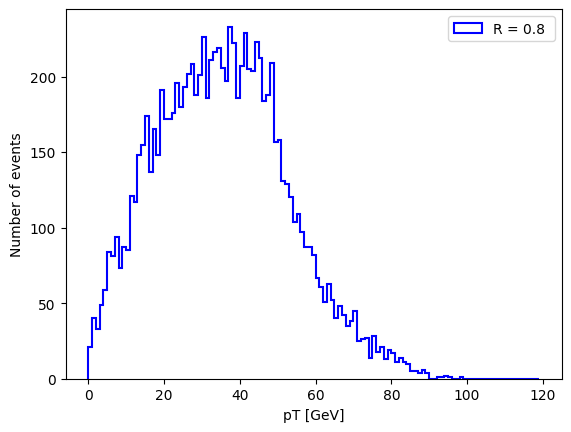

In [15]:
dijet_pt = R[2]
plt.hist(dijet_pt, bins = np.arange(0, 120), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("pT [GeV]")
plt.ylabel("Number of events")
plt.legend()
plt.show()

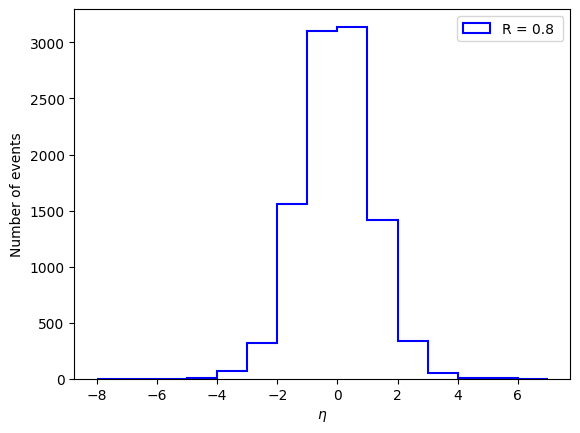

In [16]:
dijet_eta = R[3]
plt.hist(dijet_eta, bins = np.arange(-8, 8), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("$\eta$")
plt.ylabel("Number of events")
plt.legend()
plt.show()